# Filter cells based on Cell Type

In this notebook, we'll retrieve previously filtered metadata, then use the RNA data from our .h5 files to filter for T cells and identify CD4 and CD8 populations.

## Setup

Install BarMixer if not present. BarMixer is an R package that is part of the BarWare tools for barcoded scRNA-seq data, and has helper functions for easily reading cell metadata from our .h5 files.

BarMixer repository: https://github.com/AllenInstitute/BarMixer  
BarWare paper: [Swanson, et al., BMC Bioinformatics (2022)](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-022-04620-2)

In [1]:
ip <- installed.packages()
if(!"BarMixer" %in% rownames(ip)) {
    devtools::install_github(
        "alleninstitute/BarMixer",
        upgrade = "never"
    )
}

## Load packages

hise: The Human Immune System Explorer R SDK package  
BarMixer: .h5 file handling  
purrr: Functional programming tools  
dplyr: Dataframe handling functions  
ggplot2: plotting functions  
Seurat: single cell genomics methods

In [2]:
quiet_library <- function(...) { suppressPackageStartupMessages(library(...)) }
quiet_library(hise)
quiet_library(BarMixer)
quiet_library(purrr)
quiet_library(dplyr)
quiet_library(ggplot2)
quiet_library(Seurat)

## Retrieve files

Now, we'll use the HISE SDK package to retrieve the TEA-seq .h5 file outputs based on their file UUIDs. These will be placed in the `cache/` subdirectory by default.

In [3]:
h5_file_uuids <- list(
    "0a4dcc97-bc5a-4aa6-a3d3-16cf612502ce", 
    "0af11a1e-c721-40e1-9455-032416ab1aa1", 
    "1981a346-0a61-4360-a11c-2e846af8aa52", 
    "1be65739-445a-41fe-89a4-52fbbba2000d", 
    "5ed5b8a3-1a79-40fb-b47f-c38dda0f012c", 
    "636e9db3-1870-4691-832c-814588039474", 
    "63a493fb-f7cb-4544-bd3a-c55fc9c26426", 
    "7d9548ce-8468-45d6-9489-fa638e421934", 
    "d3a284cf-b101-44d4-9f88-d3683b371fa6", 
    "d5ddec3e-c699-4f04-89fa-34c9d3cfeec1", 
    "de3962ef-1b9f-4e16-a660-6d839d52e432", 
    "f9a1b436-a5cf-4950-99ba-add2c5ac0707"
)

In [4]:
fres <- hise::cacheFiles(
    h5_file_uuids
)

In [5]:
filtered_meta_uuid <- list(
   "f3db110d-4d9f-45d6-bbf7-02957f23a81e" 
)

In [6]:
fres <- hise::cacheFiles(
    filtered_meta_uuid
)

submitting request as query ID first...

retrieving files using fileIDS...



## Assemble RNA Seurat object

Next, we'll read the filtered cell metadata, then read all of the RNA matrices from the .h5 files using Barmixer's `read_h5_dgCMatrix()` function, assemble a single matrix with all cells, filter that matrix based on our filtered metadata, and assemble a Seurat object.

In [7]:
filtered_meta_file <- list.files(
    paste0("cache/", filtered_meta_uuid[[1]]),
    full.names = TRUE)
filtered_meta <- read.csv(filtered_meta_file)

In [8]:
h5_files <- list.files(
    "cache",
    pattern = ".h5",
    full.names = TRUE,
    recursive = TRUE
)

In [9]:
rna_mat_list <- map(
    h5_files,
    read_h5_dgCMatrix,
    feature_names = "name"
)

In [10]:
rna_mat <- do.call(cbind, rna_mat_list)

In [11]:
filtered_rna_mat <- rna_mat[,filtered_meta$barcodes]

In [12]:
rownames(filtered_meta) <- filtered_meta$barcodes

In [13]:
so <- CreateSeuratObject(
    counts = filtered_rna_mat,
    meta = filtered_meta,
)

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”


## RNA normalization and clustering

To identify T cells, we'll normalize and cluster the RNA data.

In [14]:
so <- FindVariableFeatures(so, nfeatures = 2000)

In [15]:
so <- NormalizeData(
    so,
    normalization.method = "LogNormalize"
)

In [16]:
so <- ScaleData(so)
so <- RunPCA(so, verbose = FALSE)

Centering and scaling data matrix



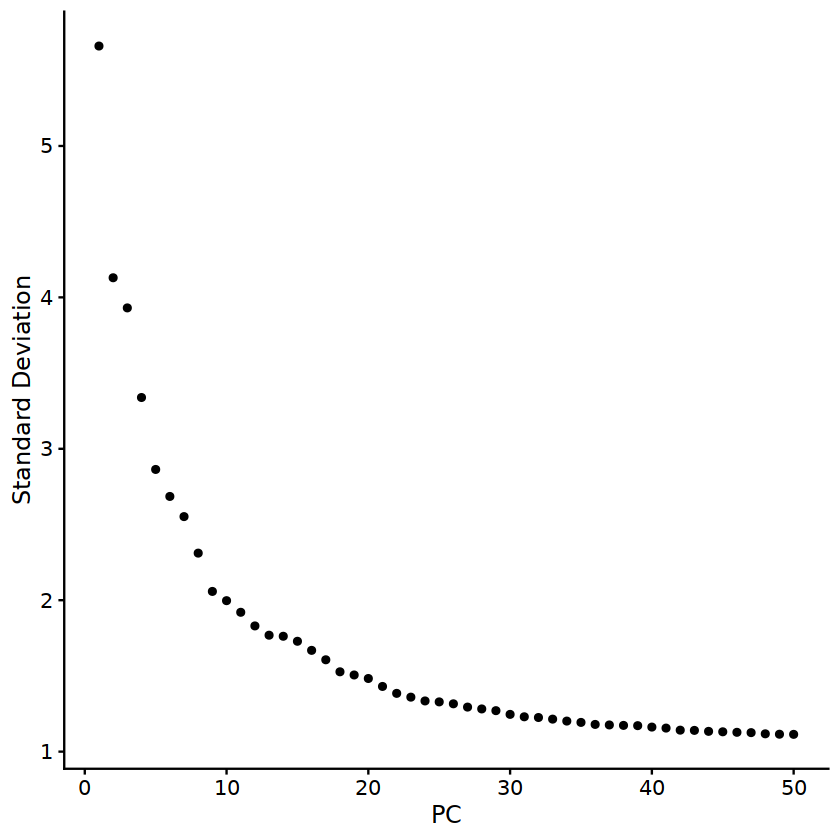

In [17]:
ElbowPlot(so, ndims = 50)

In [18]:
so <- FindNeighbors(so, dims = 1:30)

Computing nearest neighbor graph

Computing SNN



In [19]:
so <- FindClusters(so)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 158276
Number of edges: 4434033

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9164
Number of communities: 30
Elapsed time: 109 seconds


1 singletons identified. 29 final clusters.



## Filtering based on marker gene expression

In [20]:
markers <- c(
    "CD3D", "CD4", "CD8A", # T Cells
    "NCAM1", # NK Cells
    "FCN1", "CD14", "FCGR3A", # Monocytes
    "CD79A", "CD79B", # B Cells
    "ITM2C" # DCs
)

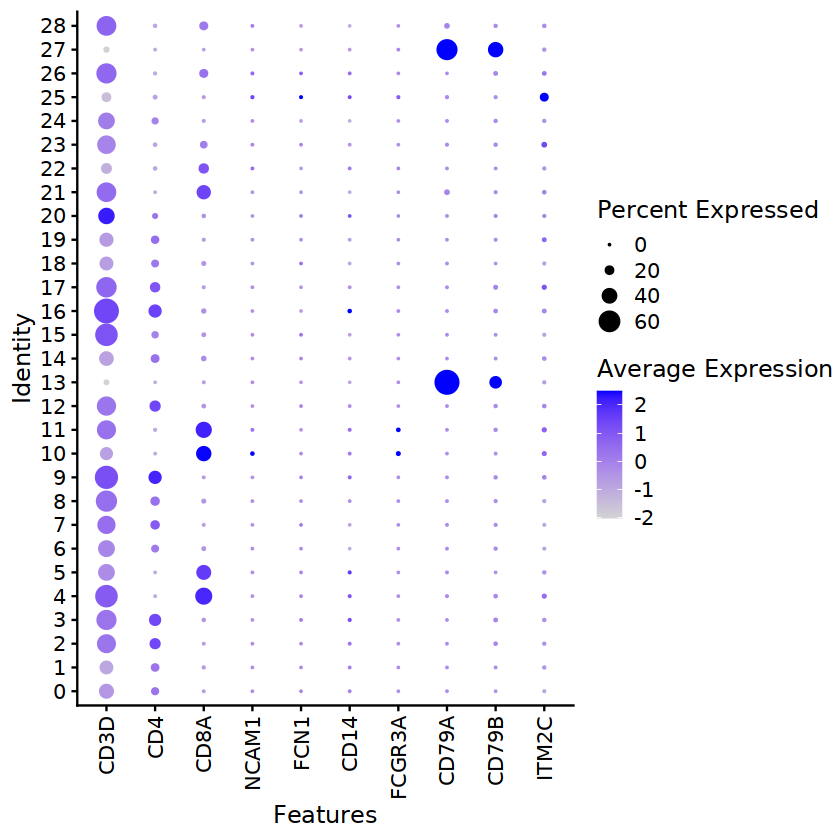

In [21]:
DotPlot(
    so,
    features = markers
)  +
  ggplot2::theme(axis.text.x = ggplot2::element_text(angle = 90, hjust = 1, vjust = 0.5))

Compute fractions > 0 per cluster to use for filtering

In [22]:
marker_mat <- so[["RNA"]]@counts[markers,]
clusters <- so@meta.data$seurat_clusters

In [23]:
marker_fracs <- map(
    markers,
    function(marker) {
        cl_list <- split(marker_mat[marker,], clusters)
        cl_frac <- map_dbl(cl_list, function(x) { sum(x > 0) / length(x) })
        cl_frac
    })
names(marker_fracs) <- markers
marker_df <- data.frame(
    cl = names(marker_fracs[[1]]),
    do.call(cbind, marker_fracs)
)

In [24]:
head(marker_df)

,cl,CD3D,CD4,CD8A,NCAM1,FCN1,CD14,FCGR3A,CD79A,CD79B,ITM2C
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0.3754590,0.148298350,0.006576424,0.0011508741,0.0008220529,0.004877514,0.0001096071,0.001918124,0.003233408,0.01249520
1,1,0.3366840,0.164104962,0.017591023,0.0012857226,0.0007597452,0.006077962,0.0007597452,0.002629887,0.007422126,0.02232482
2,2,0.5083013,0.247208272,0.007090103,0.0015361891,0.0006499261,0.007208272,0.0004135894,0.003367799,0.031078287,0.02156573
3,3,0.5468125,0.280695465,0.029276453,0.0006572265,0.0014936966,0.013682261,0.0005974786,0.002867897,0.038776364,0.02551234
4,4,0.6261801,0.007637637,0.443619391,0.0010607829,0.0010607829,0.011456455,0.0001060783,0.012623316,0.032035642,0.04858385
5,5,0.4335782,0.005660605,0.373359027,0.0012043840,0.0009635072,0.011682524,0.0001204384,0.006864989,0.002649645,0.02384680


Set cutoffs and filter clusters

In [25]:
# Remove B cells
max_cd79a <- 0.2

# Remove DCs
max_itm2c <- 0.1

In [26]:
keep_cl <- marker_df %>%
  filter(CD79A < max_cd79a,
         ITM2C < max_itm2c)

In [27]:
nrow(keep_cl)

[1] 26

How many cells are we removing?

In [28]:
n_remove <- sum(!so$seurat_clusters %in% keep_cl$cl)
paste("Removing", n_remove, "non-T cells")

frac_remove <- n_remove / ncol(so)
paste("Removing", round(frac_remove, 4), "of all cells")

n_keep <- sum(so$seurat_clusters %in% keep_cl$cl)
paste("Retaining", n_keep, "cells after filtering")

[1] "Removing 4792 non-T cells"

[1] "Removing 0.0303 of all cells"

[1] "Retaining 153484 cells after filtering"

In [29]:
so <- so[,so$seurat_clusters %in% keep_cl$cl]

## CD4 and CD8 assignment based on ADT expression

To assign CD4 and CD8 T cell identity, we'll use expression of the CD4 and CD8A ADT detection per cell.

This works a bit better than cluster-wise labeling, particularly in the case of things like CD4 CTLs that mix in with CD8 cells.

First, we'll read all of the ADT expression data from the .h5 files and select the T cells we've identified above.

In [30]:
adt_mat_list <- map(
    h5_files,
    function(h5) {
        meta <- read_h5_cell_meta(h5)  
        mat <- read_h5_dgCMatrix(
            h5,
            target = "ADT",
            feature_names = "id"
        )
        colnames(mat) <- meta$barcodes
        mat
    }
)

In [31]:
adt_mat <- do.call(cbind, adt_mat_list)

In [32]:
filtered_adt_mat <- adt_mat[,so@meta.data$barcodes]

In [33]:
so[["ADT"]] <- CreateAssayObject(counts = filtered_adt_mat)

Here, we normalize the ADT values using Centered Log Ratios, then visualize expression for each sample to identify a reasonable cutoff.

In [34]:
DefaultAssay(so) <- "ADT"

In [35]:
so <- NormalizeData(
    so,
    normalization.method = "CLR",
    margin = 2
)

Normalizing across cells



In [36]:
so$treat_time <- paste0(so$treatment, "_", so$timepoint)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



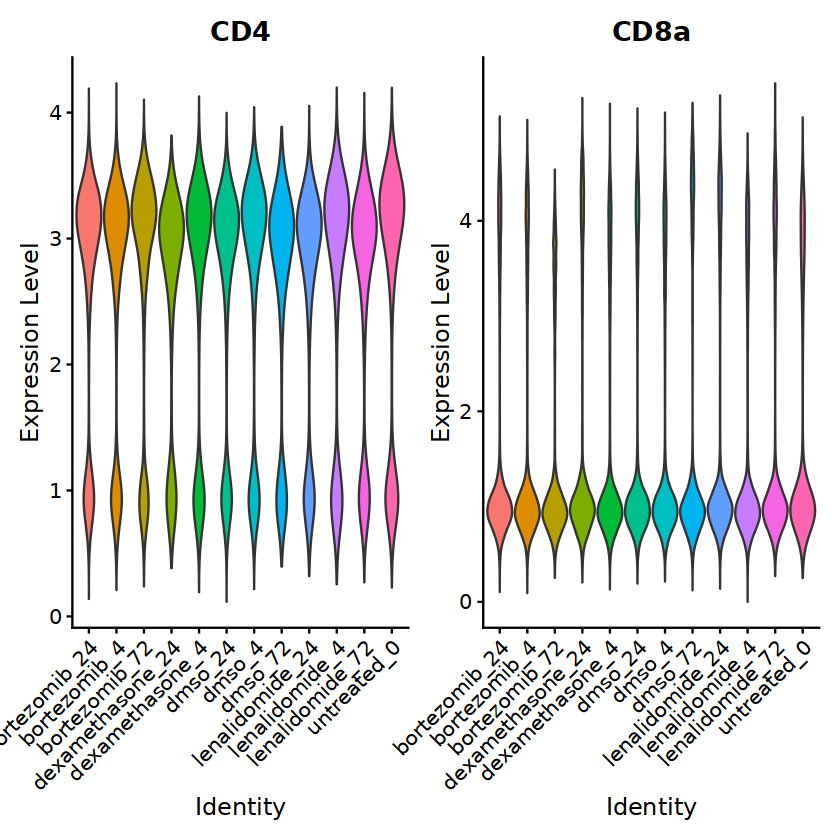

In [37]:
VlnPlot(
    so,
    features = c("CD4", "CD8a"),
    group.by = "treat_time",
    pt.size = 0
)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



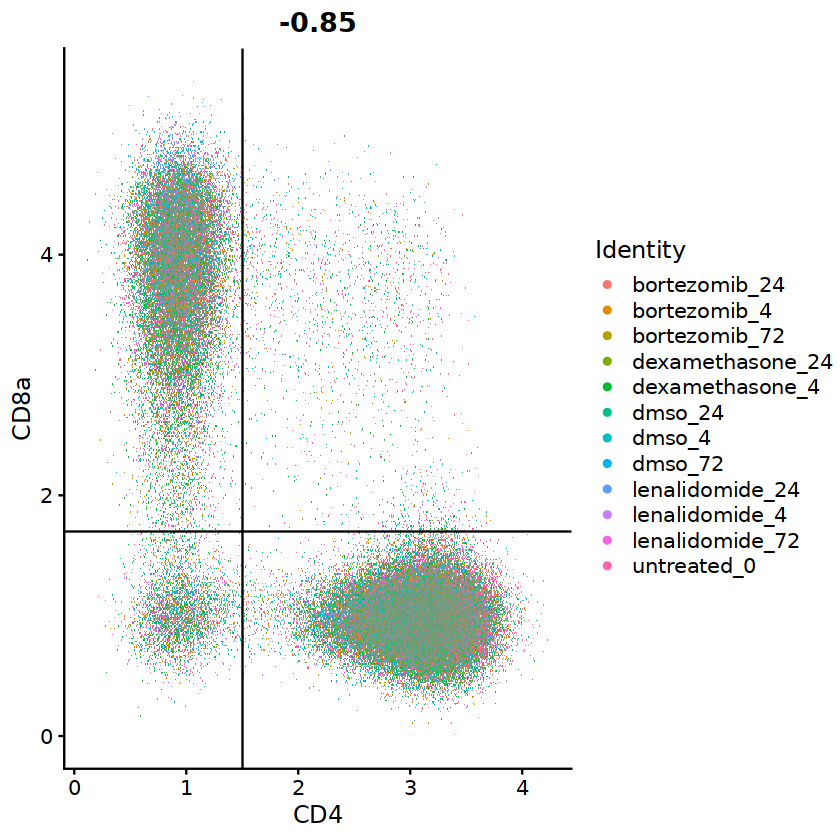

In [38]:
FeatureScatter(
    so,
    "CD4",
    "CD8a",
    group.by = "treat_time"
) +
  geom_hline(aes(yintercept = 1.7)) +
  geom_vline(aes(xintercept = 1.5))

For CD4, 1.5 looks like a good low/high cutoff. For CD8, we'll use 1.75.

In [39]:
cd4_cutoff <- 1.5
cd8_cutoff <- 1.75

In [40]:
so$CD4pos <- so[["ADT"]]@data["CD4",] > cd4_cutoff
so$CD8pos <- so[["ADT"]]@data["CD8a",] > cd8_cutoff

In [41]:
so$CD4_CD8 <- "t_dn" # Double-negative T cells by default
so$CD4_CD8[so$CD4pos & !so$CD8pos] <- "t_cd4"
so$CD4_CD8[!so$CD4pos & so$CD8pos] <- "t_cd8"
so$CD4_CD8[so$CD4pos & so$CD8pos] <- "t_dp" # Double-positive T cells

In [42]:
table(so$CD4_CD8)


 t_cd4  t_cd8   t_dn   t_dp 
114546  32868   4130   1940 

## Generate output files

For downstream use, we'll make versions of these Seurat Objects that are separate for CD4 and CD8 cells.

We'll also build filtered metadata .csv files.

In [43]:
cd4_so <- so[,so$CD4_CD8 == "t_cd4"]
cd8_so <- so[,so$CD4_CD8 == "t_cd8"]

## We'll generate clean versions of these objects for use in downstream analyses.

In [44]:
clean_cd4_meta <- cd4_so@meta.data
clean_cd4_meta$seurat_clusters <- NULL

clean_cd4_so <- CreateSeuratObject(
    counts = cd4_so[["RNA"]]@counts,
    meta.data = clean_cd4_meta
)
clean_cd4_so[["ADT"]] <- CreateAssayObject(counts = cd4_so[["ADT"]]@counts)

In [45]:
clean_cd8_meta <- cd8_so@meta.data
clean_cd8_meta$seurat_clusters <- NULL

clean_cd8_so <- CreateSeuratObject(
    counts = cd8_so[["RNA"]]@counts,
    meta.data = clean_cd8_meta
)
clean_cd8_so[["ADT"]] <- CreateAssayObject(counts = cd8_so[["ADT"]]@counts)

In [46]:
dir.create("output")

Warning message in dir.create("output"):
“'output' already exists”


In [47]:
write.csv(clean_cd4_meta,
          "output/filtered_cd4_te_metadata.csv",
          quote = FALSE, row.names = FALSE)
write.csv(clean_cd8_meta,
          "output/filtered_cd8_te_metadata.csv",
          quote = FALSE, row.names = FALSE)

In [48]:
saveRDS(clean_cd4_so,
        "output/filtered_cd4_te_seurat.rds")
saveRDS(clean_cd8_so,
        "output/filtered_cd8_te_seurat.rds")

## Store results in HISE

Finally, we store the output file in our Collaboration Space for later retrieval and use. We need to provide the UUID for our Collaboration Space (aka `studySpaceId`), as well as a title for this step in our analysis process.

The hise function `uploadFiles()` also requires the FileIDs from the original fileset for reference, which we assembled above when files were retrieved (`h5_file_uuids` and `filtered_metadata_uuid`)

In [49]:
study_space_uuid <- "40df6403-29f0-4b45-ab7d-f46d420c422e"
title <- "VRd TEA-seq CD4 and CD8 TE data"

In [50]:
out_files <- list.files(
    "output",
    full.names = TRUE
)
out_list <- as.list(out_files)

In [51]:
uploadFiles(
    files = out_list,
    studySpaceId = study_space_uuid,
    title = title,
    inputFileIds = c(h5_file_uuids,filtered_meta_uuid),
    store = "project",
    doPrompt = FALSE
)

$files
$files[[1]]
[1] "output/filtered_cd4_te_metadata.csv"

$files[[2]]
[1] "output/filtered_cd4_te_seurat.rds"

$files[[3]]
[1] "output/filtered_cd8_te_metadata.csv"

$files[[4]]
[1] "output/filtered_cd8_te_seurat.rds"


$traceId
[1] "cc0d40eb-e47f-437c-a41e-18cd4ecfbe77"

In [52]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.23.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] SeuratObject_4.1.3 Seurat_4.3.0.1     ggplot2_3.4.3      dplyr_1.1.2       
 [5] purrr_1.0.2        BarMixer_1.0.1     rhdf5_2.44.0       Matrix_1.6-1      
 [9] data.table_1.14.8  hise_2.16.0       

loaded via a namespace (and not attached):
  [1] RColorBrewer_1.1-3     jsonlite_1.8.7         magrittr_2.0